In [1]:
import numpy as np
import sys
import os
import time
import cv2
import pandas
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
#Tensorflow utilities
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
# base data path 
train_path = '/home/manu_kohli/skin/Aayush/github/WBC_project/Dataset/combined/train'
test_path = '/home/manu_kohli/skin/Aayush/github/WBC_project/Dataset/combined/test'

In [5]:
# loading data
data_generator = ImageDataGenerator(validation_split=0.2,
                                    rescale=1./255)

image_size = 128
batch_size = 32
train_generator = data_generator.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


num_classes = len(train_generator.class_indices)
num_classes = len(validation_generator.class_indices)
    

Found 20385 images belonging to 11 classes.
Found 4073 images belonging to 11 classes.


In [6]:
model = Sequential()
model.add(ResNet50(input_shape=(128,128,3),include_top = False, weights='imagenet',pooling='avg'))
model.add(Dense(num_classes, activation = 'softmax'))
model.layers[0].trainable = False

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 11)                22539     
Total params: 23,610,251
Trainable params: 22,539
Non-trainable params: 23,587,712
_________________________________________________________________


In [7]:
callbacks = [
    EarlyStopping(patience=10, verbose=1,monitor='val_loss'),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1,monitor='val_loss'),
    ModelCheckpoint('./weights/combinedABC_wA.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs = 10,
        validation_data = validation_generator,
        validation_steps=50,
        callbacks=callbacks
)

Epoch 1/10
128/128 [==============================] - 13s 105ms/step - loss: 0.5156 - acc: 0.8235

Epoch 00001: val_loss improved from 0.52964 to 0.51558, saving model to ./weights/combinedABC_wA.h5
638/638 [==============================] - 87s 136ms/step - loss: 0.6040 - acc: 0.7886 - val_loss: 0.5156 - val_acc: 0.8235
Epoch 2/10
128/128 [==============================] - 13s 104ms/step - loss: 0.5184 - acc: 0.8242

Epoch 00002: val_loss did not improve from 0.51558
638/638 [==============================] - 86s 135ms/step - loss: 0.5971 - acc: 0.7922 - val_loss: 0.5184 - val_acc: 0.8242
Epoch 3/10
128/128 [==============================] - 13s 103ms/step - loss: 0.5263 - acc: 0.8195

Epoch 00003: val_loss did not improve from 0.51558
638/638 [==============================] - 86s 135ms/step - loss: 0.5973 - acc: 0.7936 - val_loss: 0.5263 - val_acc: 0.8195
Epoch 4/10
128/128 [==============================] - 13s 103ms/step - loss: 0.5225 - acc: 0.8188

Epoch 00004: ReduceLROnPlateau

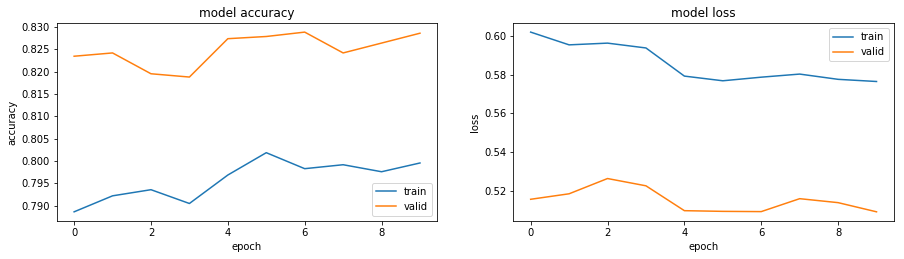

In [12]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

In [13]:
test_generator = data_generator.flow_from_directory(
    directory = test_path,
    target_size = (image_size, image_size),
    batch_size = 1,
    class_mode = 'categorical',
    shuffle = False,
    seed = 123
)

Found 8744 images belonging to 11 classes.


In [14]:
scores = model.evaluate_generator(generator=test_generator,steps=1,verbose = 1)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

8744/8744 [==============================] - 249s 28ms/step - loss: 0.9003 - acc: 0.6970

acc: 69.70%


In [15]:
pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)
predicted_class_indices = np.argmax(pred, axis = 1)

8744/8744 [==============================] - 175s 20ms/step
